In [1]:
#!pip install h5py

In [138]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

matplotlib.rc('font', **font)

## Part 1 Loading Cosmological Simulation Data

### 1.3

In [4]:
f = h5py.File('cutout_117258.hdf5', 'r')

In [5]:
list(f.keys())

['Header', 'PartType0', 'PartType1', 'PartType4', 'PartType5']

In [6]:
f['PartType4'].keys()

<KeysViewHDF5 ['BirthPos', 'BirthVel', 'Coordinates', 'GFM_InitialMass', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged', 'GFM_StellarFormationTime', 'GFM_StellarPhotometrics', 'Masses', 'ParticleIDs', 'Potential', 'StellarHsml', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>

In [7]:
dset = f['PartType4']['Coordinates']

### Adopted Hubble factor: h = 0.6774. Reference: [TNG50 paper 2.1 The initial conditions](https://arxiv.org/pdf/1902.05553.pdf).


In [8]:
h = 0.6774
dset.shape

(558775, 3)

### 1.4

In [9]:
f_2 = h5py.File("testfile.hdf5", "w")
physical_dset = f_2.create_dataset("default", dset.shape)

In [10]:
%%time
physical_dset[:] = dset[:] * h

CPU times: user 6.68 ms, sys: 9.92 ms, total: 16.6 ms
Wall time: 16.1 ms


In [11]:
physical_dset # now in units of physical kpc

<HDF5 dataset "default": shape (558775, 3), type "<f4">

In [12]:
x_co = physical_dset[:,0]
y_co = physical_dset[:,1]
z_co = physical_dset[:,2]

In [13]:
masses = f['PartType4']['Masses'][:]
masses = masses * h

In [14]:
masses = masses * 1e10 # in solar masses

### 1.5

In [15]:
bin_size = 1000

In [16]:
x_range = np.amax(x_co) - np.amin(x_co)
y_range = np.amax(y_co) - np.amin(y_co)
dxdy = x_range/bin_size * y_range/bin_size # surface element

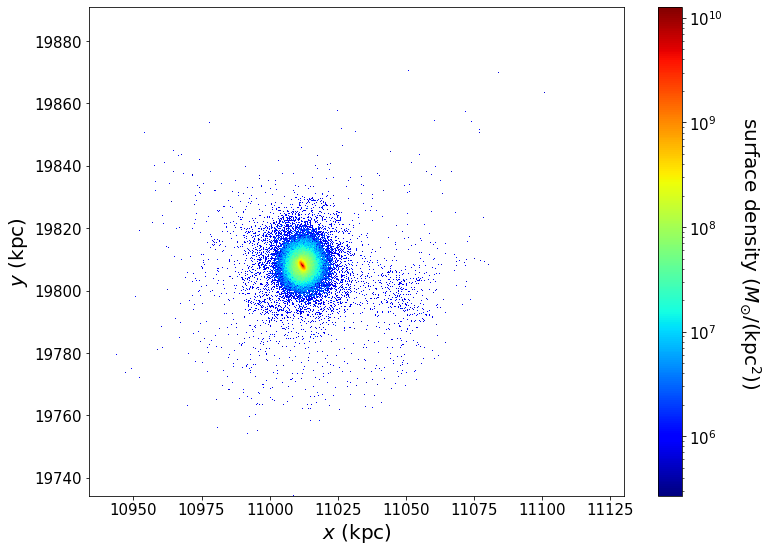

In [17]:
fig = plt.figure(figsize = (12, 9))
plt.hist2d(x_co, y_co, bins=(bin_size, bin_size), cmap=plt.cm.jet, weights = masses/dxdy, 
           norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel("$x$ (kpc)", fontsize = 20)
plt.ylabel("$y$ (kpc)", fontsize = 20)
fig.text(0.89, 0.5, 'surface density ($M_{\odot}$/kpc$^2$)', 
         ha='center', va='center', rotation=270, fontsize = 20)
plt.savefig('Figure_1.pdf')

## Part 2 Defining reference frame

In [18]:
def find_cm(coordinate, mass):
    """ Find the center of mass of a system. 
    
        coordinate: array-like
        
        mass: array-like
    """
    return np.sum(np.multiply(coordinate, mass))/np.sum(mass)

In [19]:
velocities = f['PartType4']['Velocities'][:]
velocities = velocities * h

In [20]:
velocities

array([[-136.90292 ,  -93.612076,  156.59727 ],
       [-134.56635 ,  -94.40673 ,  143.43849 ],
       [-140.8965  ,  -93.57056 ,  148.69646 ],
       ...,
       [ -91.402664, -114.10192 ,  142.35417 ],
       [-102.90578 ,  -71.91143 ,  110.83328 ],
       [-102.105156,  -70.80764 ,  122.33662 ]], dtype=float32)

### 2.6(a)

In [21]:
x_cm = find_cm(x_co, masses)
x_cm

11012.109

In [22]:
y_cm = find_cm(y_co, masses)
y_cm

19808.092

In [23]:
z_cm = find_cm(z_co, masses)
z_cm

17703.562

In [24]:
vx_cm = find_cm(velocities[:,0], masses)
vx_cm

-147.80736

In [25]:
vy_cm = find_cm(velocities[:,1], masses)
vy_cm

-83.94938

In [26]:
vz_cm = find_cm(velocities[:,2], masses)
vz_cm

144.83304

In [27]:
new_x = x_co - x_cm
new_x

array([-1.0449219e-01, -8.6914062e-02, -1.4355469e-01, ...,
        1.0385547e+02,  1.0043945e+02,  1.1808984e+02], dtype=float32)

In [28]:
new_y = y_co - y_cm
new_y

array([-2.3437500e-02, -4.4921875e-02, -1.9531250e-03, ...,
        7.6753906e+01,  8.2917969e+01,  7.8376953e+01], dtype=float32)

In [29]:
new_z = z_co - z_cm
new_z

array([-4.1015625e-02, -3.3203125e-02, -4.6875000e-02, ...,
       -3.2261719e+01, -2.7689453e+01, -3.7876953e+01], dtype=float32)

In [30]:
new_vx = velocities[:,0] - vx_cm
new_vx

array([10.904434, 13.241013,  6.910858, ..., 56.404694, 44.90158 ,
       45.7022  ], dtype=float32)

In [31]:
new_vy = velocities[:,1] - vy_cm
new_vy

array([ -9.662697, -10.457352,  -9.621178, ..., -30.152542,  12.037949,
        13.141739], dtype=float32)

In [32]:
new_vz = velocities[:,2] - vz_cm
new_vz

array([ 11.764236 ,  -1.3945465,   3.8634186, ...,  -2.4788666,
       -33.999756 , -22.496422 ], dtype=float32)

In [33]:
new_r = np.squeeze(np.dstack((new_x, new_y, new_z)))
new_v = np.squeeze(np.dstack((new_vx, new_vy, new_vz)))

### 2.6(b)

In [34]:
def angular_momentum(mass, positions, velocities):
    """ Returns the angular momentum of a system in (Lx, Ly, Lz). 
    
        positions: array-like
        
        mass: array-like
        
        Return:
        
        The x,y,z components of the calculated angular momentum.
    """
    Lx = np.sum(np.cross(positions, velocities)[:,0]*mass)
    Ly = np.sum(np.cross(positions, velocities)[:,1]*mass)
    Lz = np.sum(np.cross(positions, velocities)[:,2]*mass)
    return np.array([Lx, Ly, Lz])

In [35]:
L = angular_momentum(masses, new_r, new_v)

### 2.6(c)

In [36]:
e_z = L/np.linalg.norm(L)
e_z

array([0.20362978, 0.03564345, 0.97839886], dtype=float32)

In [37]:
e_x = np.cross(np.array([1,0,0]), e_z)
e_x = e_x/np.linalg.norm(e_x)
e_x

array([ 0.        , -0.99933707,  0.03640624])

In [38]:
np.linalg.norm(e_x)

1.0

In [39]:
e_y = np.cross(e_x, e_z)
e_y = e_y/np.linalg.norm(e_y)
e_y

array([-0.97904796,  0.00741339,  0.2034948 ])

In [40]:
np.linalg.norm(e_y)

1.0

### 2.6(d)

In [41]:
T_matrix = np.squeeze(np.dstack((e_x, e_y, e_z)))
T_matrix = np.linalg.inv(T_matrix)

In [42]:
def transform(coordinate):
    """ Transforms the old coordinates to the new coordinates we just defined.
        
        coordinate: float, array-like
            in groups of three: (x, y, z)
        
        Return:
        The transformed new coordinates.
    """
    return np.matmul(T_matrix, coordinate)

In [43]:
new_r

array([[-1.0449219e-01, -2.3437500e-02, -4.1015625e-02],
       [-8.6914062e-02, -4.4921875e-02, -3.3203125e-02],
       [-1.4355469e-01, -1.9531250e-03, -4.6875000e-02],
       ...,
       [ 1.0385547e+02,  7.6753906e+01, -3.2261719e+01],
       [ 1.0043945e+02,  8.2917969e+01, -2.7689453e+01],
       [ 1.1808984e+02,  7.8376953e+01, -3.7876953e+01]], dtype=float32)

In [44]:
new_r = transform(new_r.T).T # transform the positions arrays to the new coordinate system
new_r

array([[ 2.19287380e-02,  9.37826453e-02, -6.22427630e-02],
       [ 4.36832942e-02,  7.80033488e-02, -5.17853682e-02],
       [ 2.45287806e-04,  1.30993626e-01, -7.51640814e-02],
       ...,
       [-7.78775518e+01, -1.07675570e+02, -7.68098982e+00],
       [-8.38710690e+01, -1.03354998e+02, -3.68338386e+00],
       [-7.97039523e+01, -1.22742344e+02, -1.02185355e+01]])

In [45]:
x_co = new_r[:,0]
y_co = new_r[:,1]

In [46]:
x_range = np.amax(x_co) - np.amin(x_co)
y_range = np.amax(y_co) - np.amin(y_co)
dxdy = x_range/bin_size * y_range/bin_size # surface element

### 2.7(a)

CPU times: user 51.6 s, sys: 464 ms, total: 52.1 s
Wall time: 53.6 s


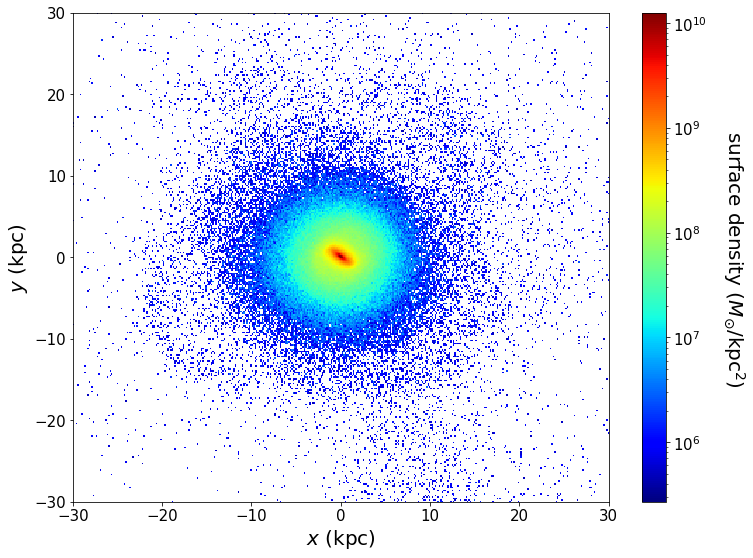

In [47]:
%%time
fig = plt.figure(figsize = (12, 9))
plt.hist2d(x_co, y_co, bins=(bin_size, bin_size), cmap=plt.cm.jet, weights = masses/dxdy, 
           norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel("$x$ (kpc)", fontsize = 20)
plt.ylabel("$y$ (kpc)", fontsize = 20)
fig.text(0.89, 0.5, 'surface density ($M_{\odot}$/kpc$^2$)', 
         ha='center', va='center', rotation=270, fontsize = 20)
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.savefig('Figure_2.pdf')

### 2.7(b)

In [48]:
x_co

array([ 2.19287380e-02,  4.36832942e-02,  2.45287806e-04, ...,
       -7.78775518e+01, -8.38710690e+01, -7.97039523e+01])

In [49]:
y_co

array([ 9.37826453e-02,  7.80033488e-02,  1.30993626e-01, ...,
       -1.07675570e+02, -1.03354998e+02, -1.22742344e+02])

In [107]:
xedges, yedges = np.linspace(-30, 30, 1000), np.linspace(-30, 30, 1000)
x_range, y_range = 60, 60
dxdy = x_range/bin_size * y_range/bin_size # surface element

In [108]:
H, xedges, yedges = np.histogram2d(x_co, y_co, bins=(xedges, yedges), weights = masses/dxdy)

# Histogram does not follow Cartesian convention,
# therefore transpose H for visualization purposes.

H = H.T

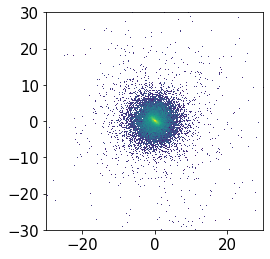

In [109]:
plt.imshow(H, interpolation='None', origin='lower', extent=[xedges[0],
           xedges[-1], yedges[0], yedges[-1]], norm=matplotlib.colors.LogNorm())

In [110]:
H.shape

(999, 999)

In [127]:
radial_sigma = np.diagonal(H)[300:500][::-1]

In [135]:
radial_sigma = np.log(radial_sigma)

/tmp/ipykernel_836/3982082480.py:1: RuntimeWarning: divide by zero encountered in log
  radial_sigma = np.log(radial_sigma)


In [143]:
radial_sigma = np.where(radial_sigma == -np.inf, np.NaN, radial_sigma)

In [152]:
from scipy.optimize import curve_fit
radii = np.linspace(0, 30 * np.sqrt(2) * 2/5, 200)

In [153]:
def linear(x, a, b):
    return a*x + b

In [155]:
valid = ~(np.isnan(radial_sigma))
popt, pcov = curve_fit(linear, radii[valid], radial_sigma[valid])

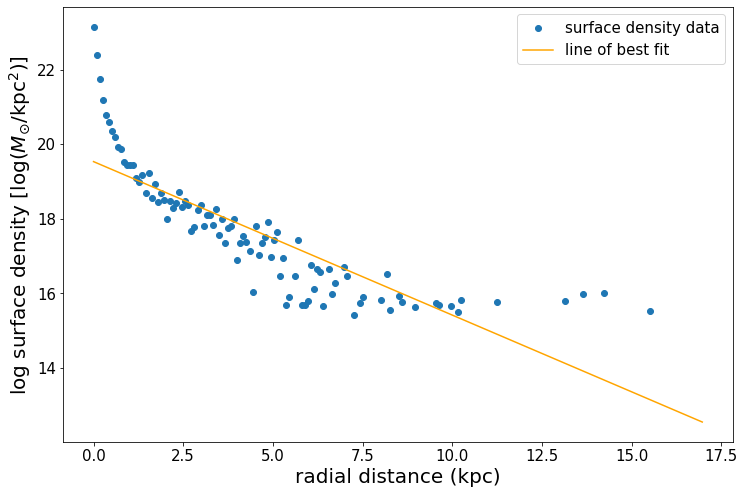

In [160]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(radii, radial_sigma, label = "surface density data")
plt.plot(radii, linear(radii, *popt), label = "line of best fit", color = "orange")
plt.xlabel("radial distance (kpc)", fontsize = 20)
plt.ylabel("log surface density [$\log(M_{\odot}$/kpc$^2)$]", fontsize = 20)
plt.legend()
plt.savefig('Figure_3.pdf')

### 2.7(c)

The slope is:

In [161]:
popt[0] 

-0.41146011435754315

Thus the scale-length is:

In [163]:
R_d = -1/popt[0]
R_d

2.430369226823862